In [1]:
import numpy as np
import NegotiationTools as nt
import matplotlib.pyplot as plt
from NegotiationConfig import *
from skimage.draw import rectangle
import pandas as pd
import seaborn as sb

stats = nt.StatisticsLogger()
neg = nt.NegTools()

## Templates
A template is the basic form of the ground truth and predictions. It is then converted into a prediction by replicating it for each label/agent. Different objects are labeled with integer numbers, with 0 being the background.

In [2]:
W = 5
H = 5
templates = dict()

templates['pixel_spot'] = np.zeros((W, H), dtype=np.uint8)
templates['pixel_spot'][2,2] = 1

templates['single_sq'] = np.zeros((W, H), dtype=np.uint8)
templates['single_sq'][tuple(rectangle(start=(1,1), extent=(3,3), shape=(W,H)))] = 1

templates['multi_sq'] = np.zeros((W, H), dtype=np.uint8)
templates['multi_sq'][1,1] = 1
templates['multi_sq'][1,3] = 2
templates['multi_sq'][3,1] = 3
templates['multi_sq'][3,3] = 4

def template_overlapped(size, overlap):
    template = np.zeros((size, size), dtype=np.uint8)
    half = int(size/2)
    quarter = int(half/2)
    offset = int(overlap*(size-2)/4)
    
    template[quarter+1:size-quarter-1, 1+offset:half+offset] = 1
    template[quarter+1:size-quarter-1, half-offset:size-1-offset] = 2
    template[quarter+1:size-quarter-1, half-offset:half+offset] = 3
    # Draw the squares in an inverse fashion
    plt.imshow(template)


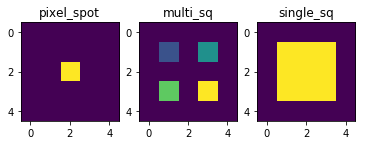

In [3]:
for i, (name, templ) in enumerate(templates.items()):
    plt.subplot(1, len(templates.items()), i+1)
    plt.imshow(templ)
    plt.title(name)

## Synthetic Samples
Synthetic samples are generated by simulating the softmax output of the agents across the labels upon a given te

In [69]:
def generate_samples(template, objects_gt, confidences):
    '''
    Simulates the agent output given an input confidence vector and a ground truth.
    template: the sample template to be used
    objects_gt: List of ordinal labels corresponding to each object in the template (including the background).
    agent predictions: nested list structures. The shape must be (agents, objects, labels) where object is the number of different segmentation areas in the template (EXCLUDING the background). 
    '''
    n_labels = len(CHANNEL_NAMES)
    n_agents = len(AGENT_NAMES)
    
    # Input checking
    
    assert np.all(np.around(np.array(confidences).sum(axis=-1), decimals=4)==1.0), "Confidences does not sum to 1.0"
    
    # Ground truth generation
    
    gt = list()
    for current_label in range(n_labels):
        gt_slice = np.zeros_like(template)
        # Iterate on template objects
        for obj_template_value in np.unique(template):
            # Paint the object if the object_gt indicates the current label for this object
            if objects_gt[obj_template_value] == current_label:
                gt_slice = np.where(template == obj_template_value, 1.0, gt_slice)
        gt.append(gt_slice)
    gt = np.stack(gt, axis=-1)
    
    # Proposals generation
    proposals = list()
    for agent in range(n_agents):
        # plt.figure(figsize=(12,6))
        
        ag_proposal = list()
        for current_label in range(n_labels):
            pr_slice = np.zeros_like(template, dtype=np.float32)
            # Iterate on template objects
            for obj_template_value in np.unique(template):
                if obj_template_value == 0:
                    if current_label == 0:
                        value = 1.
                    else:
                        value = 0.
                    pr_slice = np.where(template == obj_template_value, value, pr_slice)
                    continue
                    
                # Paint the object if the object_gt indicates the current label for this object
                value = confidences[agent][obj_template_value-1][current_label]
                pr_slice = np.where(template == obj_template_value, value, pr_slice)
            
#             plt.subplot(1, n_labels, current_label+1)
#             plt.imshow(pr_slice, cmap='Greys_r', vmin=0.0, vmax=1.0)
            ag_proposal.append(pr_slice)
        
        ag_proposal = np.stack(ag_proposal, axis=-1)
        proposals.append(ag_proposal)
    proposals = np.stack(proposals)
    
    return gt, proposals

def run_experiment(experiment, a, b):
    ''' Runs a given experiment with the given parameters and returns a DataFrame with the corresponding statistics'''
    gt, prop = experiment(a, b)

    mask = np.logical_not(neg.get_consensus(prop))
    if np.all(~mask):
        # Consensus may be enforced by construction, in these case we consider all the image
        mask = None

    agr_majority = neg.compute_majority_voting(prop, binary_strategy='maximum')
    agr_mean = neg.mean_proposal(prop, binary_strategy='maximum')
    agr_max = neg.max_proposal(prop)

    results = pd.DataFrame()

    mv_results = pd.DataFrame()
    mv_results = mv_results.append(stats.compute_statistics(gt, agr_majority, '', mask=mask), ignore_index=True, sort=False)
    mv_results['method'] = 'majority voting'
    results = results.append(mv_results, ignore_index=True, sort=False)

    mean_results = pd.DataFrame()
    mean_results = mean_results.append(stats.compute_statistics(gt, agr_mean, '', mask=mask), ignore_index=True, sort=False)
    mean_results['method'] = 'mean'
    results = results.append(mean_results, ignore_index=True, sort=False)

    max_results = pd.DataFrame()
    max_results = max_results.append(stats.compute_statistics(gt, agr_max, '', mask=mask), ignore_index = True, sort=False)
    max_results['method'] = 'maximum'
    results = results.append(max_results, ignore_index=True, sort=False)

    results['a'] = np.around(a, decimals=4)
    results['b'] = np.around(b, decimals=4)

    return results

def robustness(experiment, amin=0, amax=1, bmin=0, bmax=1, steps=10):
    ''' Perform the given experiment by varying the a and b parameters within the given range for the given number of steps. Returns a DataFrame with the statistics'''
    log = pd.DataFrame()
    for a in np.linspace(amin, amax, num=steps, endpoint=True):
        for b in np.linspace(bmin, bmax, num=steps, endpoint=True):
            log = log.append(run_experiment(experiment, a, b), ignore_index=True, sort=False)
    return log


def show_heatmap(data, metric):
    ''' Show the heatmap for one experiment. 
        data: must be a DataFrame having an integer index and at least the columns 'a', 'b', 'method' and the remaining columns are statistics that could be shown.
        metric: name of the column to display in the heatmap
    '''
    sb.set()
    sb.set_style('whitegrid')
    all_methods = data['method'].unique()
    plt.figure(figsize=(36,9))
    for m, method in enumerate(all_methods):
        pivoted = data[data['method']==method][['a', 'b', metric]].pivot('a', 'b')[metric]
        plt.subplot(1, len(all_methods), m+1)
        ax = sb.heatmap(pivoted, vmin=0.0, vmax=1.0)
        ax.invert_yaxis()
        plt.title(method + " ({})".format(metric))
    plt.show()

### 1a
Template: single box.

Agent A has confidence "a" in label 1 and the remaining (1-a) is equally spread between the other labels 

Agents B, C, D has confidence "b" in label 1 and confidence (1-b)/5 in labels 0, 1, 3, 4, with b < a

In [ ]:
# Experiment 1

def exp_1_confidences(a, b):
    '''
    Generate a confidence matrix for the experiment 1
    a: Confidence of agent 1 in label 1
    b: Confidence of agents 2, 3, 4 in label 2
    '''
    nota = (1-a)/(len(CHANNEL_NAMES)-1)
    notb = (1-b)/(len(CHANNEL_NAMES)-1)
    confidences = list()
    for ag in range(len(AGENT_NAMES)):
        if ag == 0:
            labs = list()
            for lab in range(len(CHANNEL_NAMES)):
                labs.append(a if lab==1 else nota)
            confidences.append([labs])
        else:
            labs = list()
            for lab in range(len(CHANNEL_NAMES)):
                labs.append(b if lab==2 else notb)
            confidences.append([labs])        
    return confidences

exp_1 = lambda a, b: generate_samples(templates['single_sq'], objects_gt=[0, 1], confidences=exp_1_confidences(a, b))
data = robustness(exp_1, amin=1/5, bmin=1/5)

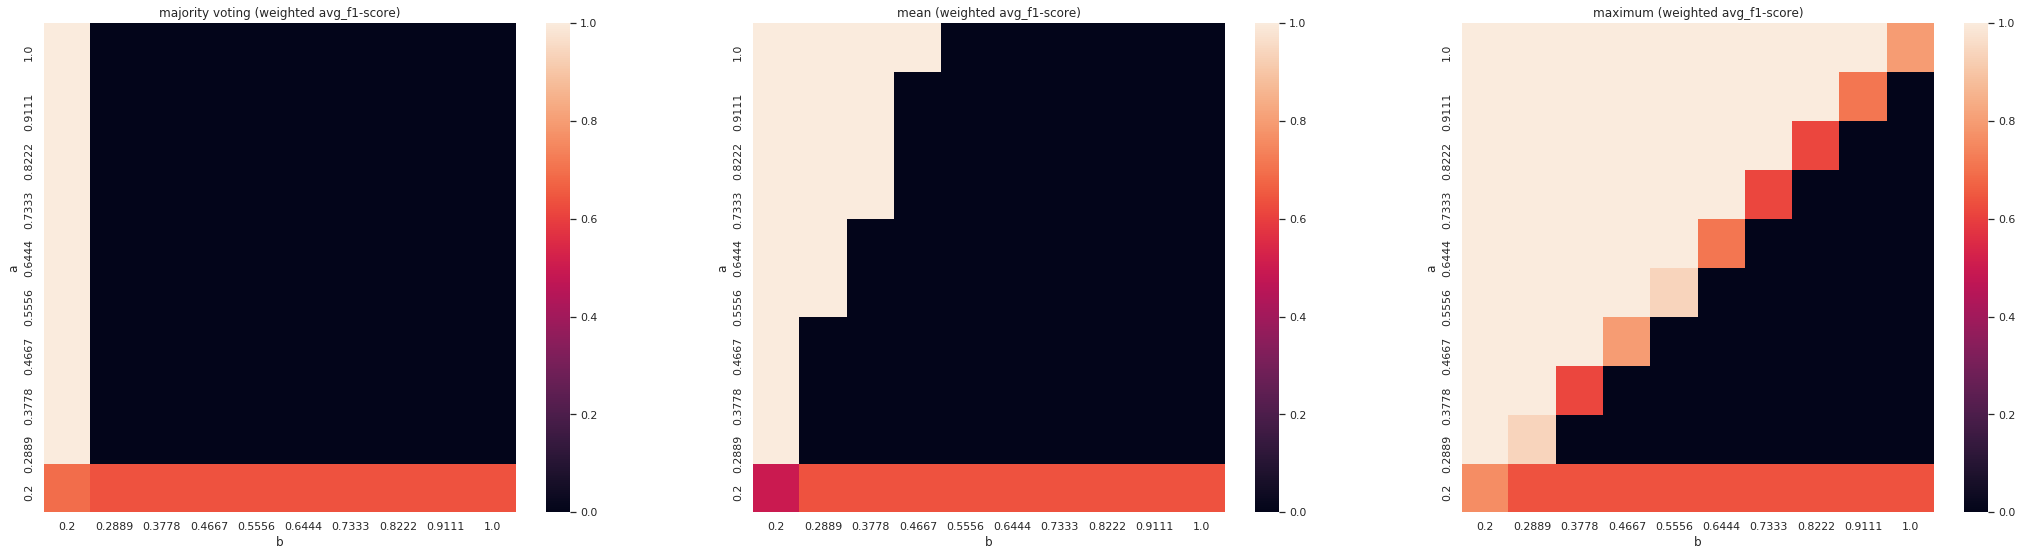

In [71]:
show_heatmap(data, 'weighted avg_f1-score')

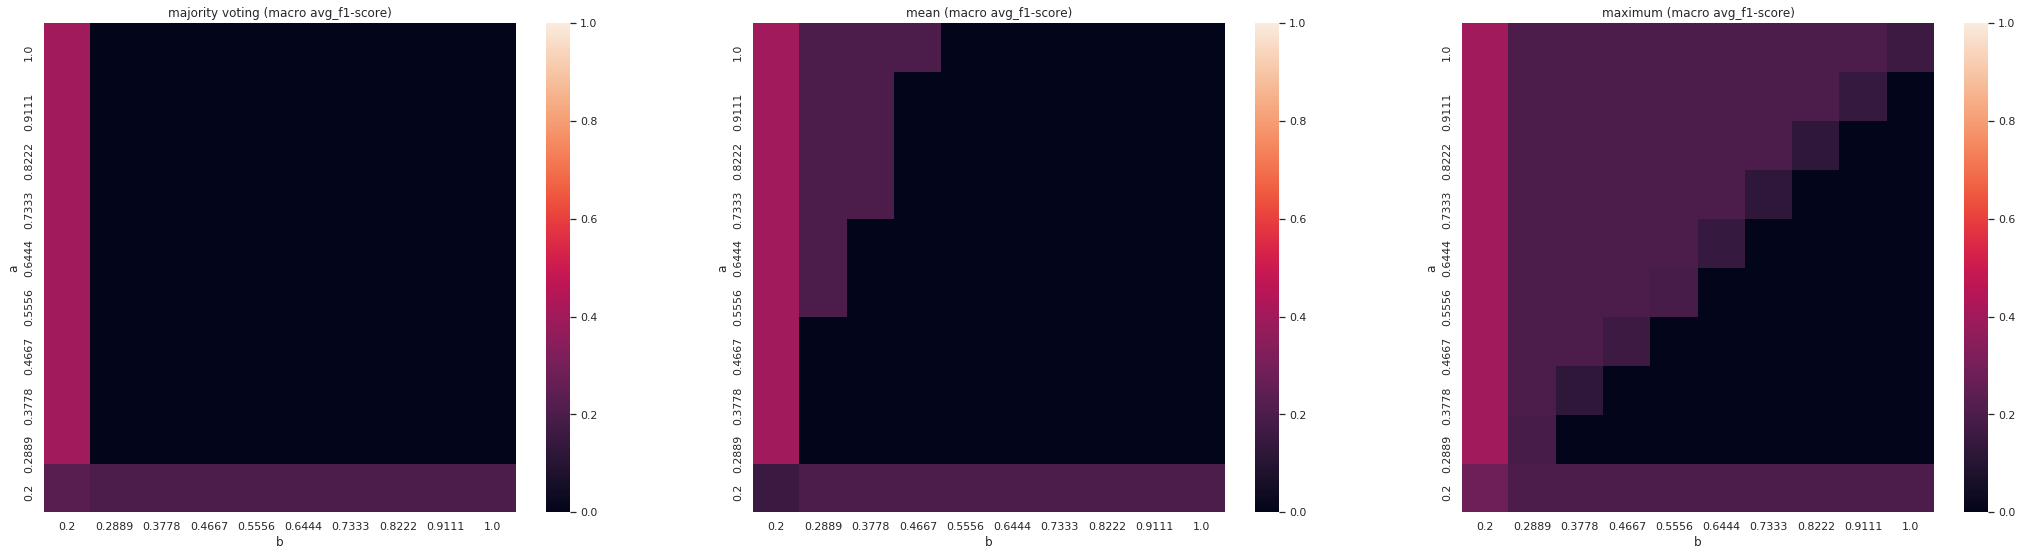

In [72]:
show_heatmap(data, 'macro avg_f1-score')

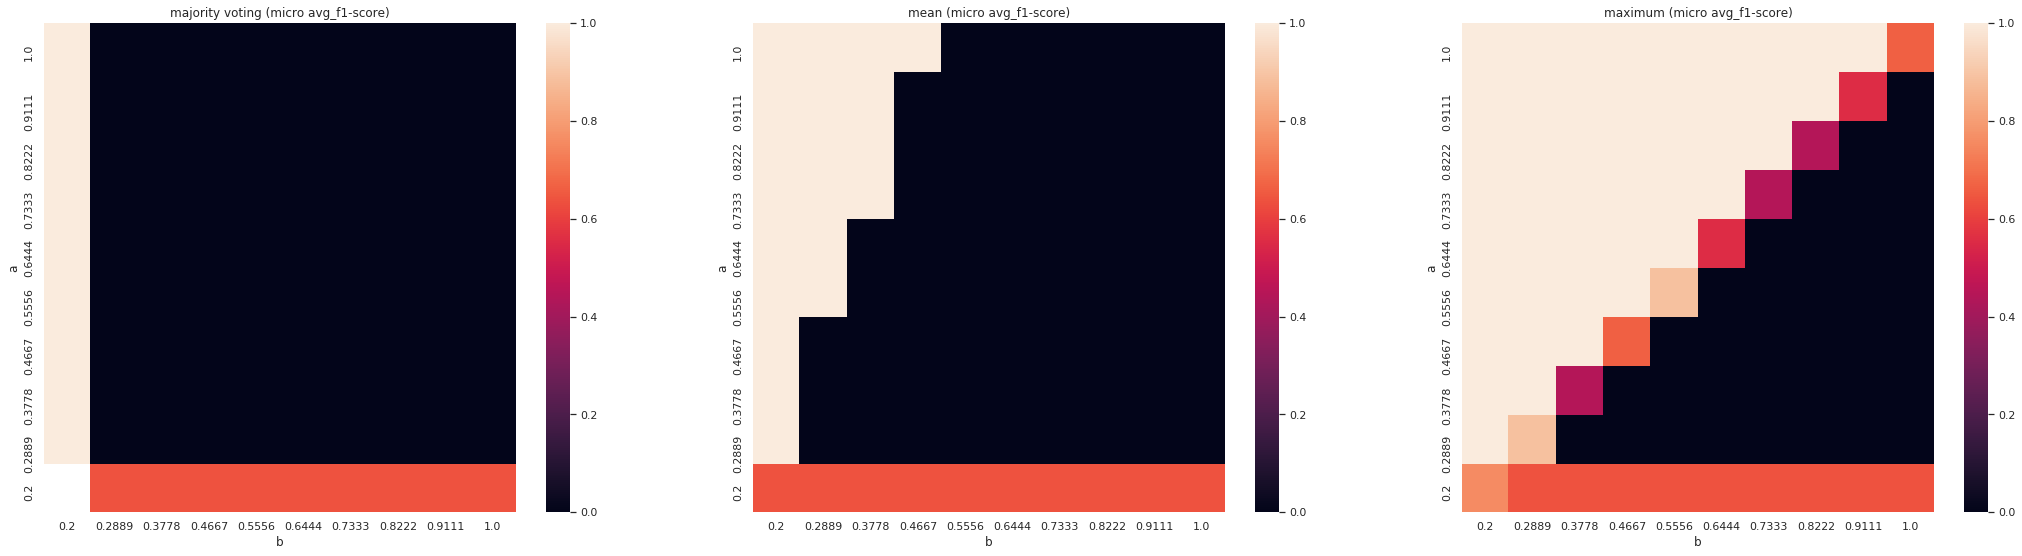

In [73]:
show_heatmap(data, 'micro avg_f1-score')

### 2
Template: multi squares.
The ground truth is composed of a different prediction for each object in the template. That is, each object i has label Li.
The agents are symmetrical. Each agent Ai has confidence alpha for the object i and confidence beta for the remaining objects/labels.

In [74]:
def exp_2_confidences(a, b, template):
    '''
    Generate a confidence matrix for the experiment 2
    a: Confidence of the agents in the label they are most proficient
    b: Confidence of the agents in the other labels
    '''
    nota = (1-a)/(len(CHANNEL_NAMES)-1)
    notb = (1-b)/(len(CHANNEL_NAMES)-1)
    
    agents = list()
    for ag in range(len(AGENT_NAMES)):
        objs = list()
        for obj in np.unique(template):
            if obj==0:
                continue # Skipping the background (managed by generate_samples)
            labs = list()
            for lab in range(len(CHANNEL_NAMES)):
                #labs.append((ag, obj, lab))
                if ag == obj -1:
                    if lab == obj:
                        labs.append(a)
                    else:
                        labs.append(nota)
                else:
                    if lab == obj:
                        labs.append(b)
                    else:
                        labs.append(notb)
            objs.append(labs)
        agents.append(objs)
    return agents

template = templates['multi_sq']
exp_2 = lambda a, b: generate_samples(template, objects_gt=[0, 1, 2, 3, 4], confidences=exp_2_confidences(a, b, template))

#nt.plot(proposals=prop, ground_truth=gt)
data = robustness(exp_2, amin=1/5, bmin=1/5)

/usr/local/lib/python3.5/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.5/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.5/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


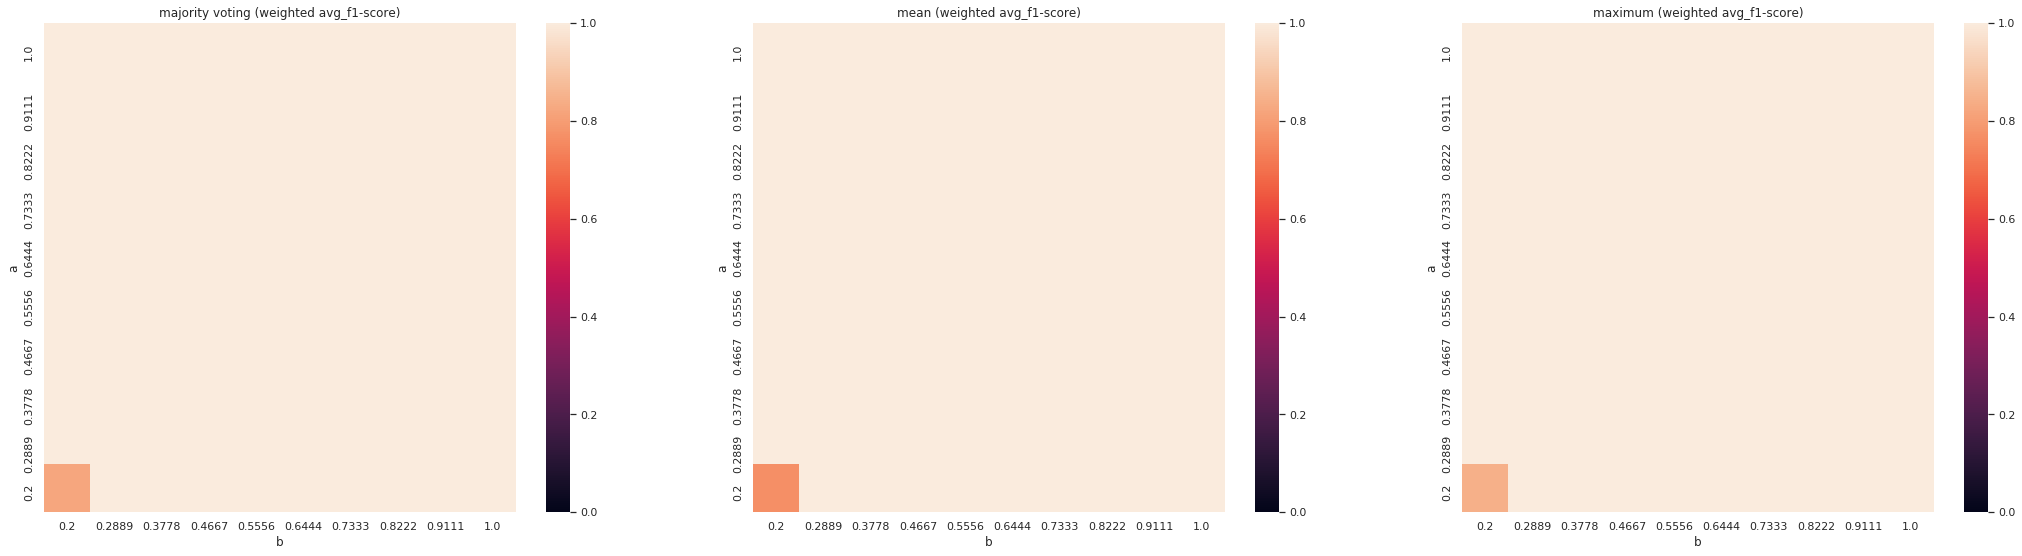

In [75]:
show_heatmap(data, 'weighted avg_f1-score')

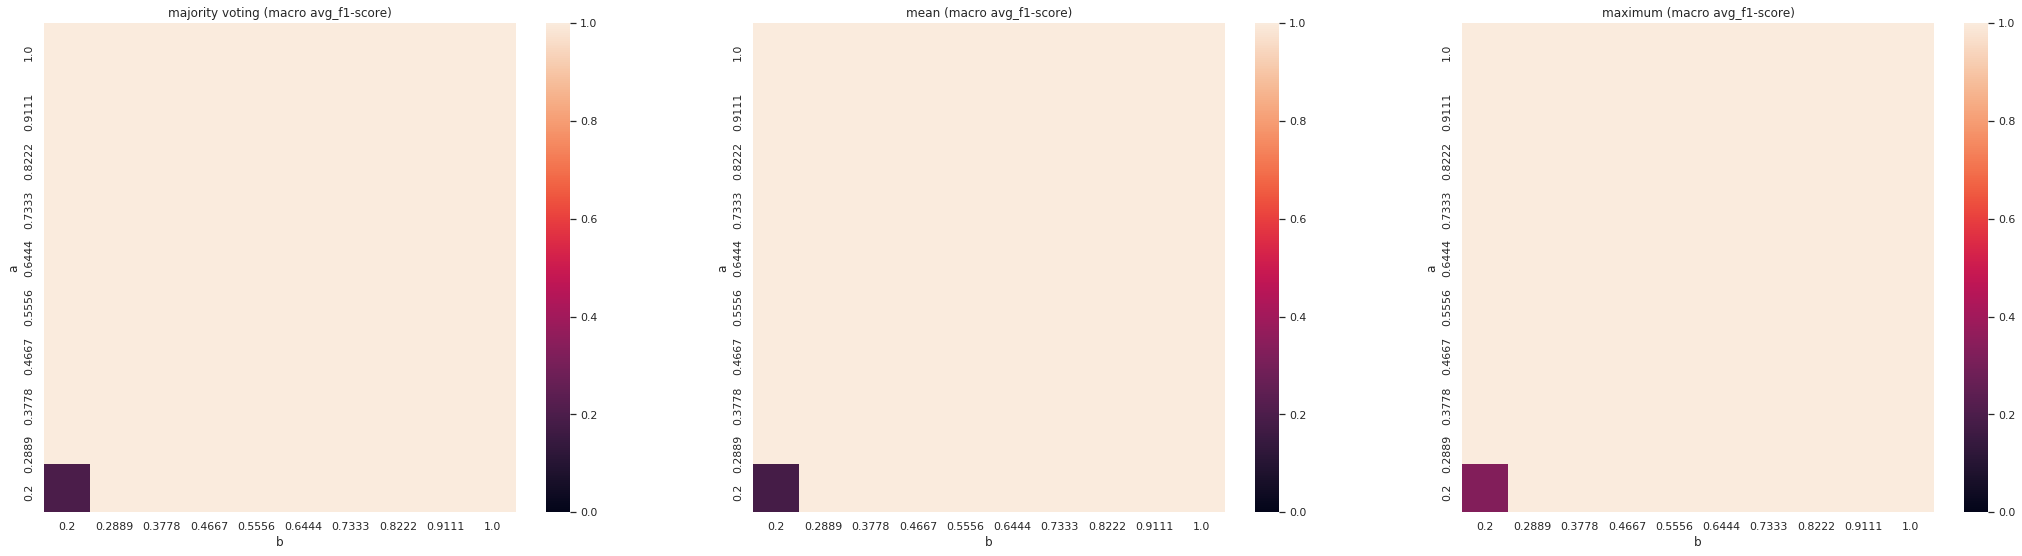

In [76]:
show_heatmap(data, 'macro avg_f1-score')

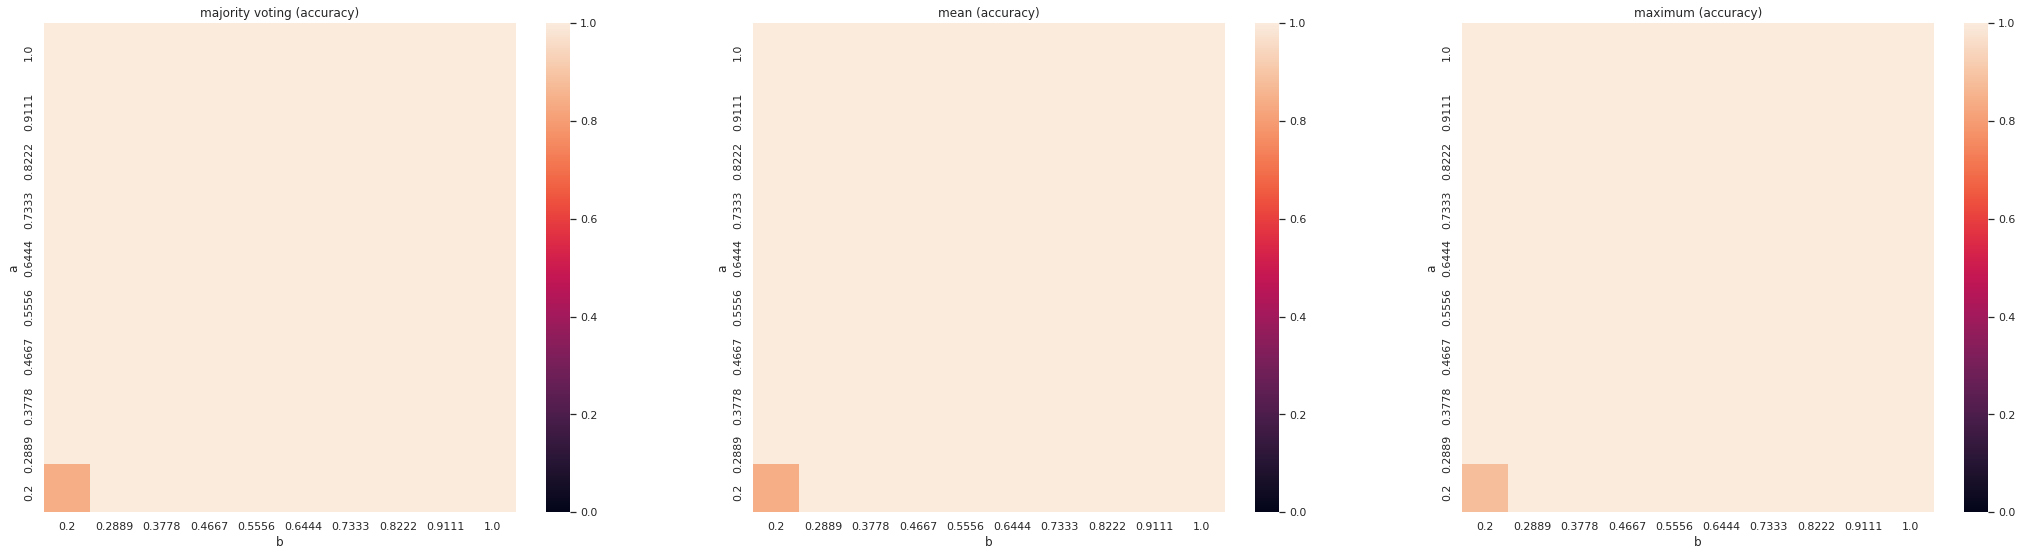

In [79]:
show_heatmap(data, 'accuracy')

In [78]:
data

,accuracy,bird_f1-score,bird_precision,bird_recall,bird_support,cat_f1-score,cat_precision,cat_recall,cat_support,dog_f1-score,...,other_precision,other_recall,other_support,weighted avg_f1-score,weighted avg_precision,weighted avg_recall,weighted avg_support,method,a,b
0,0.84,0.0,0.0,0.0,1.0,0.000000,0.0,0.0,1.0,0.0,...,0.954545,1.0,21.0,0.820465,0.801818,0.84,25.0,majority voting,0.2,0.2000
1,0.84,0.0,0.0,0.0,1.0,0.000000,0.0,0.0,1.0,0.0,...,0.840000,1.0,21.0,0.766957,0.705600,0.84,25.0,mean,0.2,0.2000
2,0.88,0.0,0.0,0.0,1.0,0.666667,0.5,1.0,1.0,0.0,...,0.954545,1.0,21.0,0.847132,0.821818,0.88,25.0,maximum,0.2,0.2000
3,1.00,1.0,1.0,1.0,1.0,1.000000,1.0,1.0,1.0,1.0,...,1.000000,1.0,21.0,1.000000,1.000000,1.00,25.0,majority voting,0.2,0.2889
4,1.00,1.0,1.0,1.0,1.0,1.000000,1.0,1.0,1.0,1.0,...,1.000000,1.0,21.0,1.000000,1.000000,1.00,25.0,mean,0.2,0.2889
5,1.00,1.0,1.0,1.0,1.0,1.000000,1.0,1.0,1.0,1.0,...,1.000000,1.0,21.0,1.000000,1.000000,1.00,25.0,maximum,0.2,0.2889
6,1.00,1.0,1.0,1.0,1.0,1.000000,1.0,1.0,1.0,1.0,...,1.000000,1.0,21.0,1.000000,1.000000,1.00,25.0,majority voting,0.2,0.3778
7,1.00,1.0,1.0,1.0,1.0,1.000000,1.0,1.0,1.0,1.0,...,1.000000,1.0,21.0,1.000000,1.000000,1.00,25.0,mean,0.2,0.3778
8,1.00,1.0,1.0,1.0,1.0,1.000000,1.0,1.0,1.0,1.0,...,1.000000,1.0,21.0,1.000000,1.000000,1.00,25.0,maximum,0.2,0.3778
9,1.00,1.0,1.0,1.0,1.0,1.000000,1.0,1.0,1.0,1.0,...,1.000000,1.0,21.0,1.000000,1.000000,1.00,25.0,majority voting,0.2,0.4667


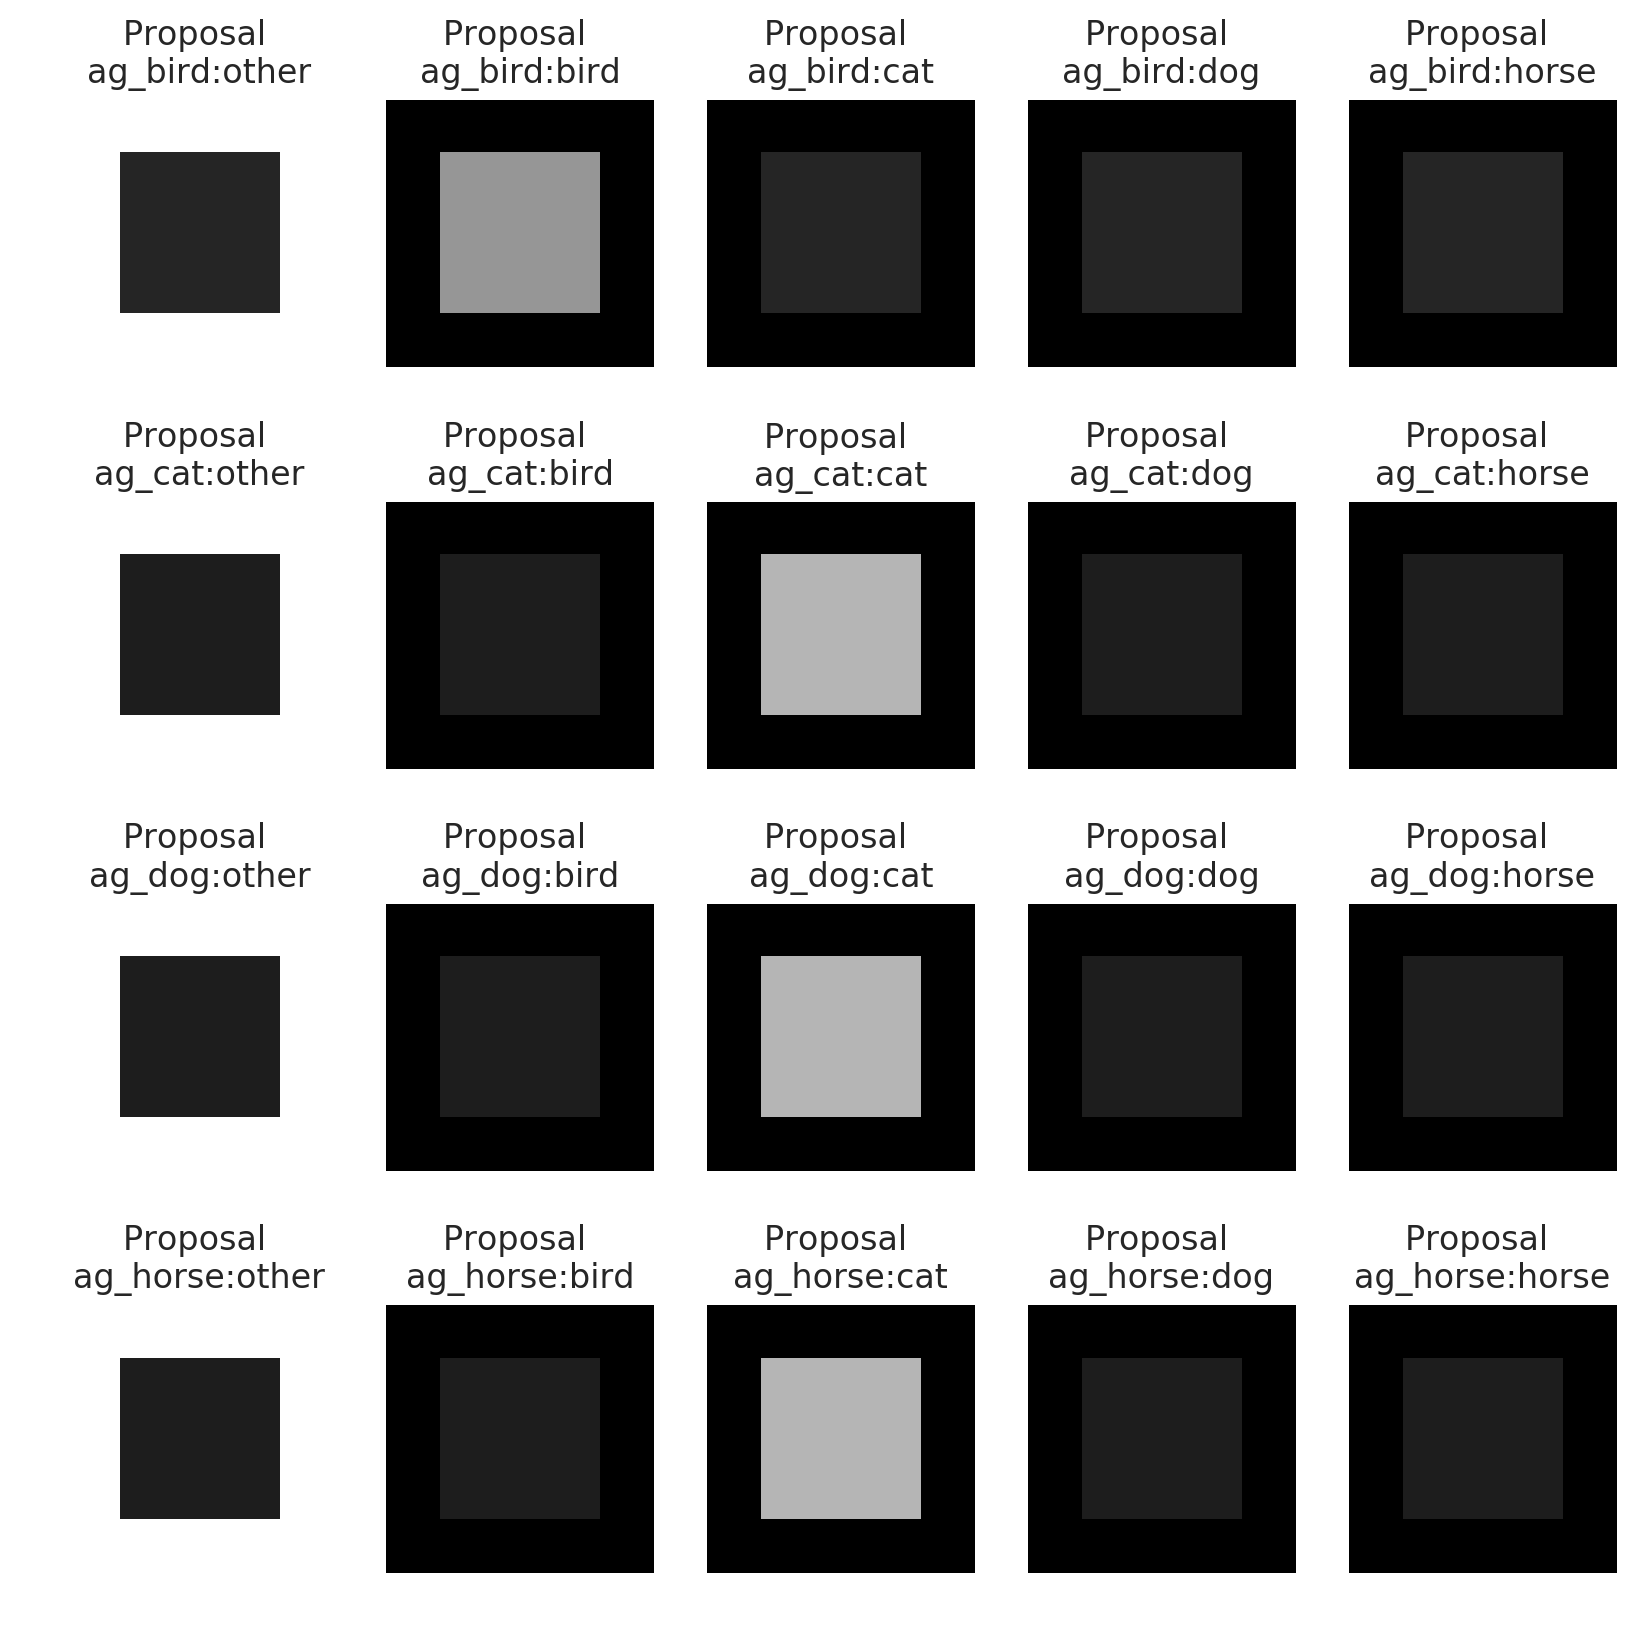

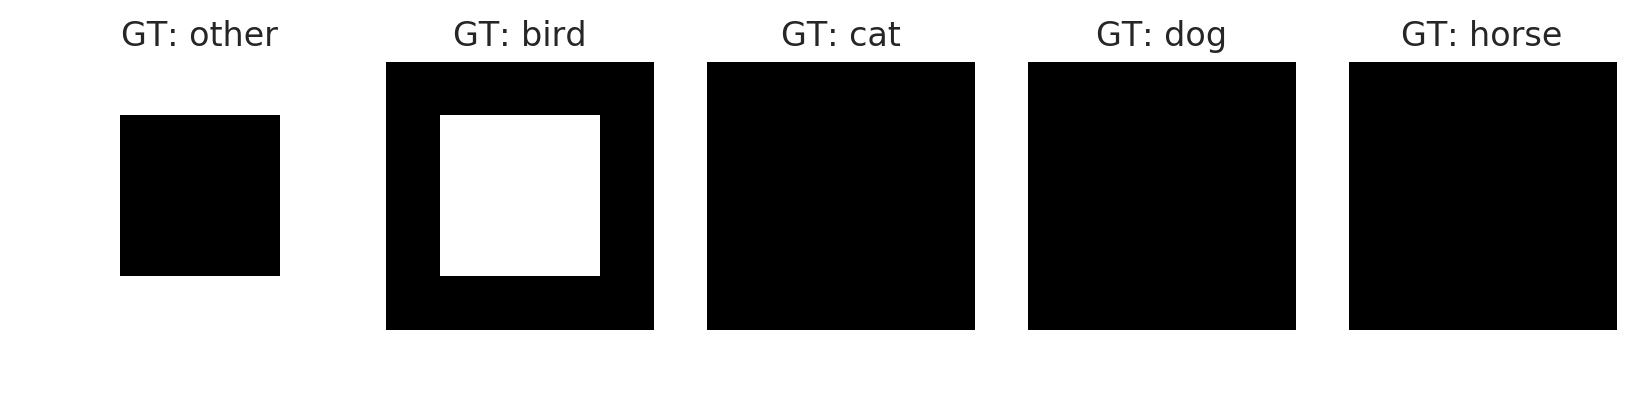

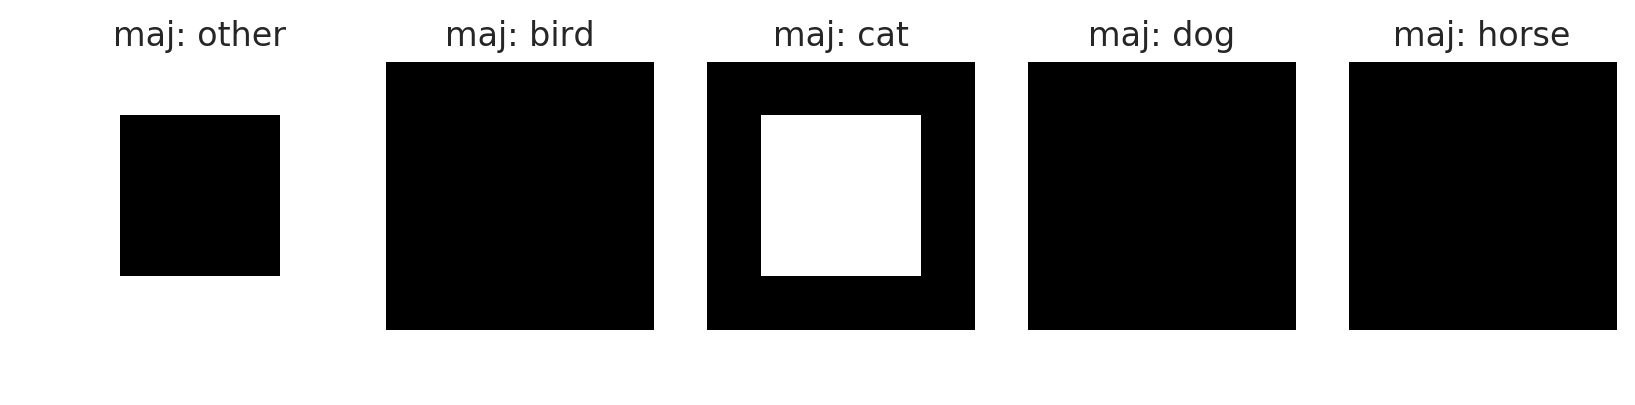

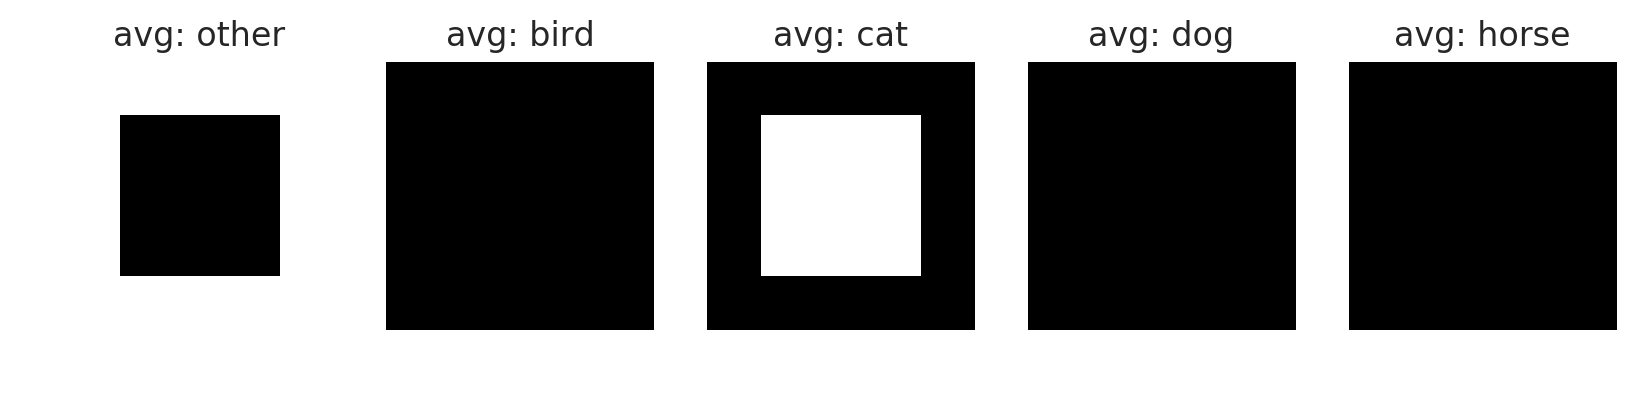

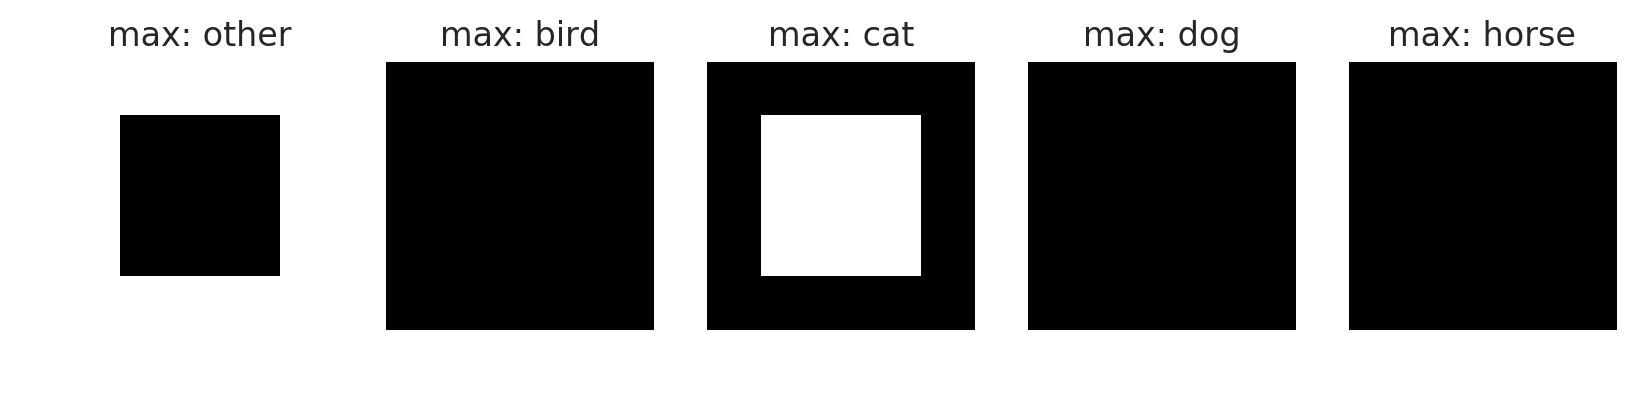

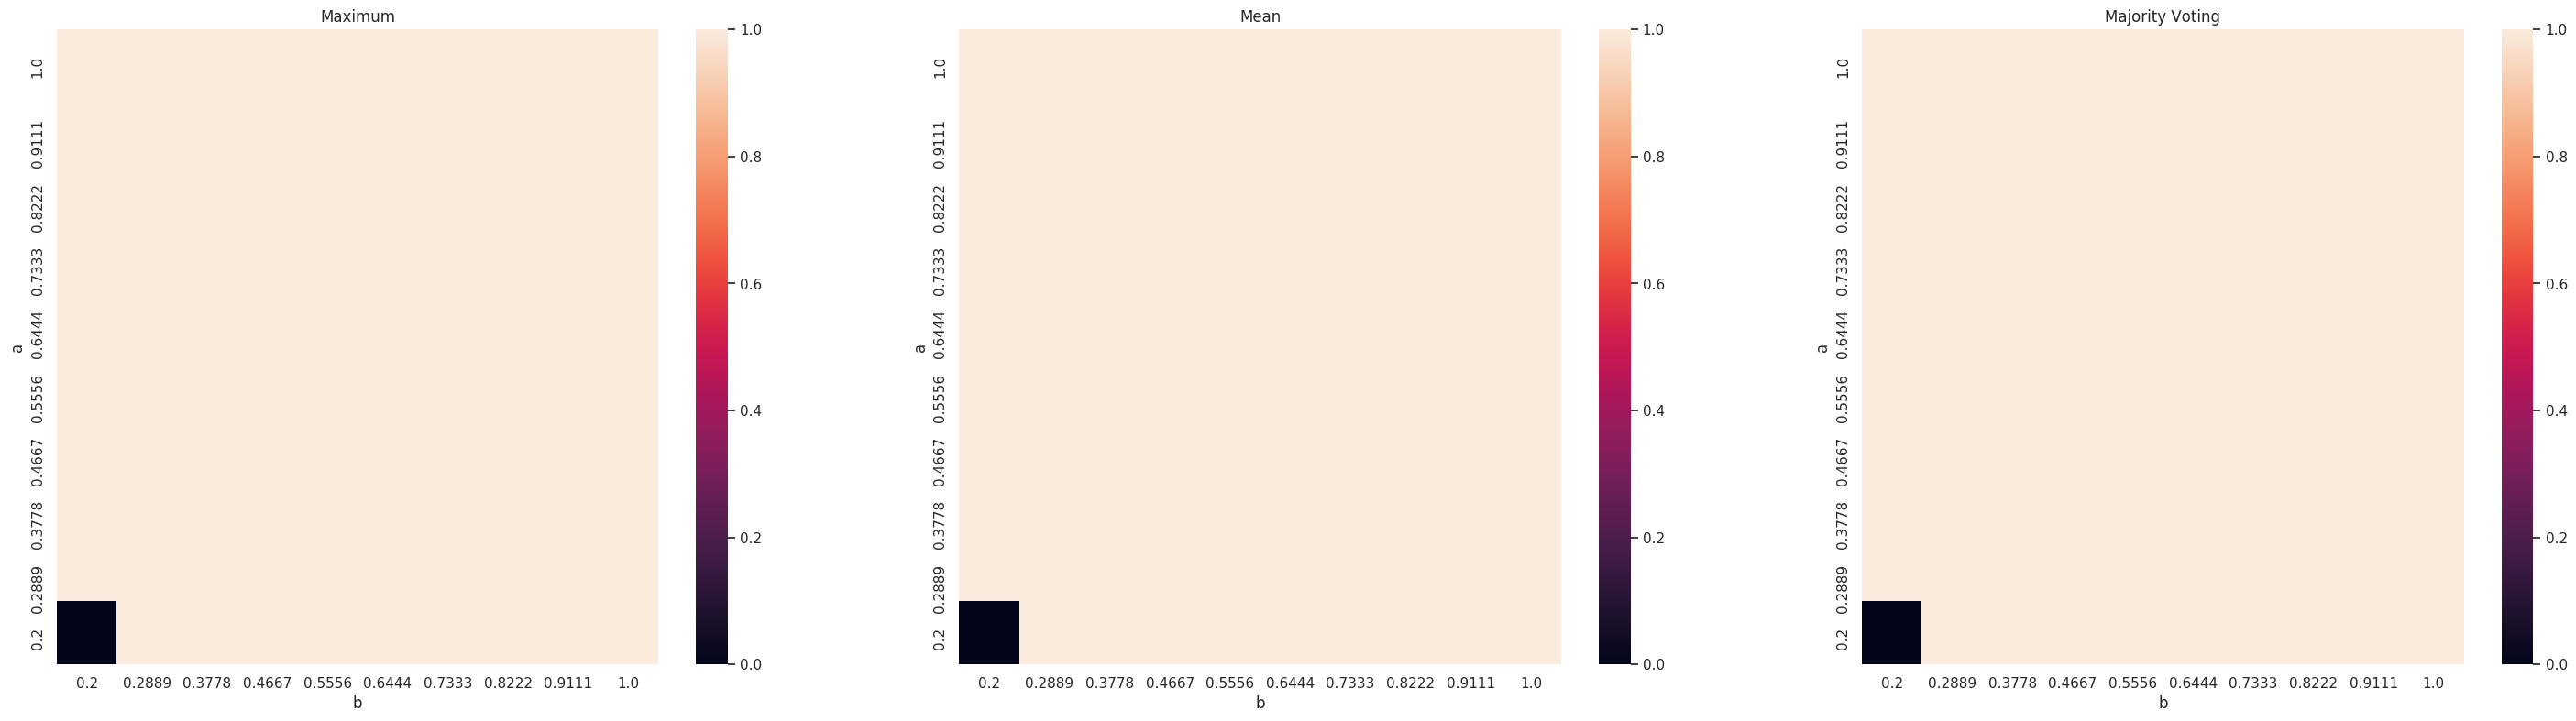

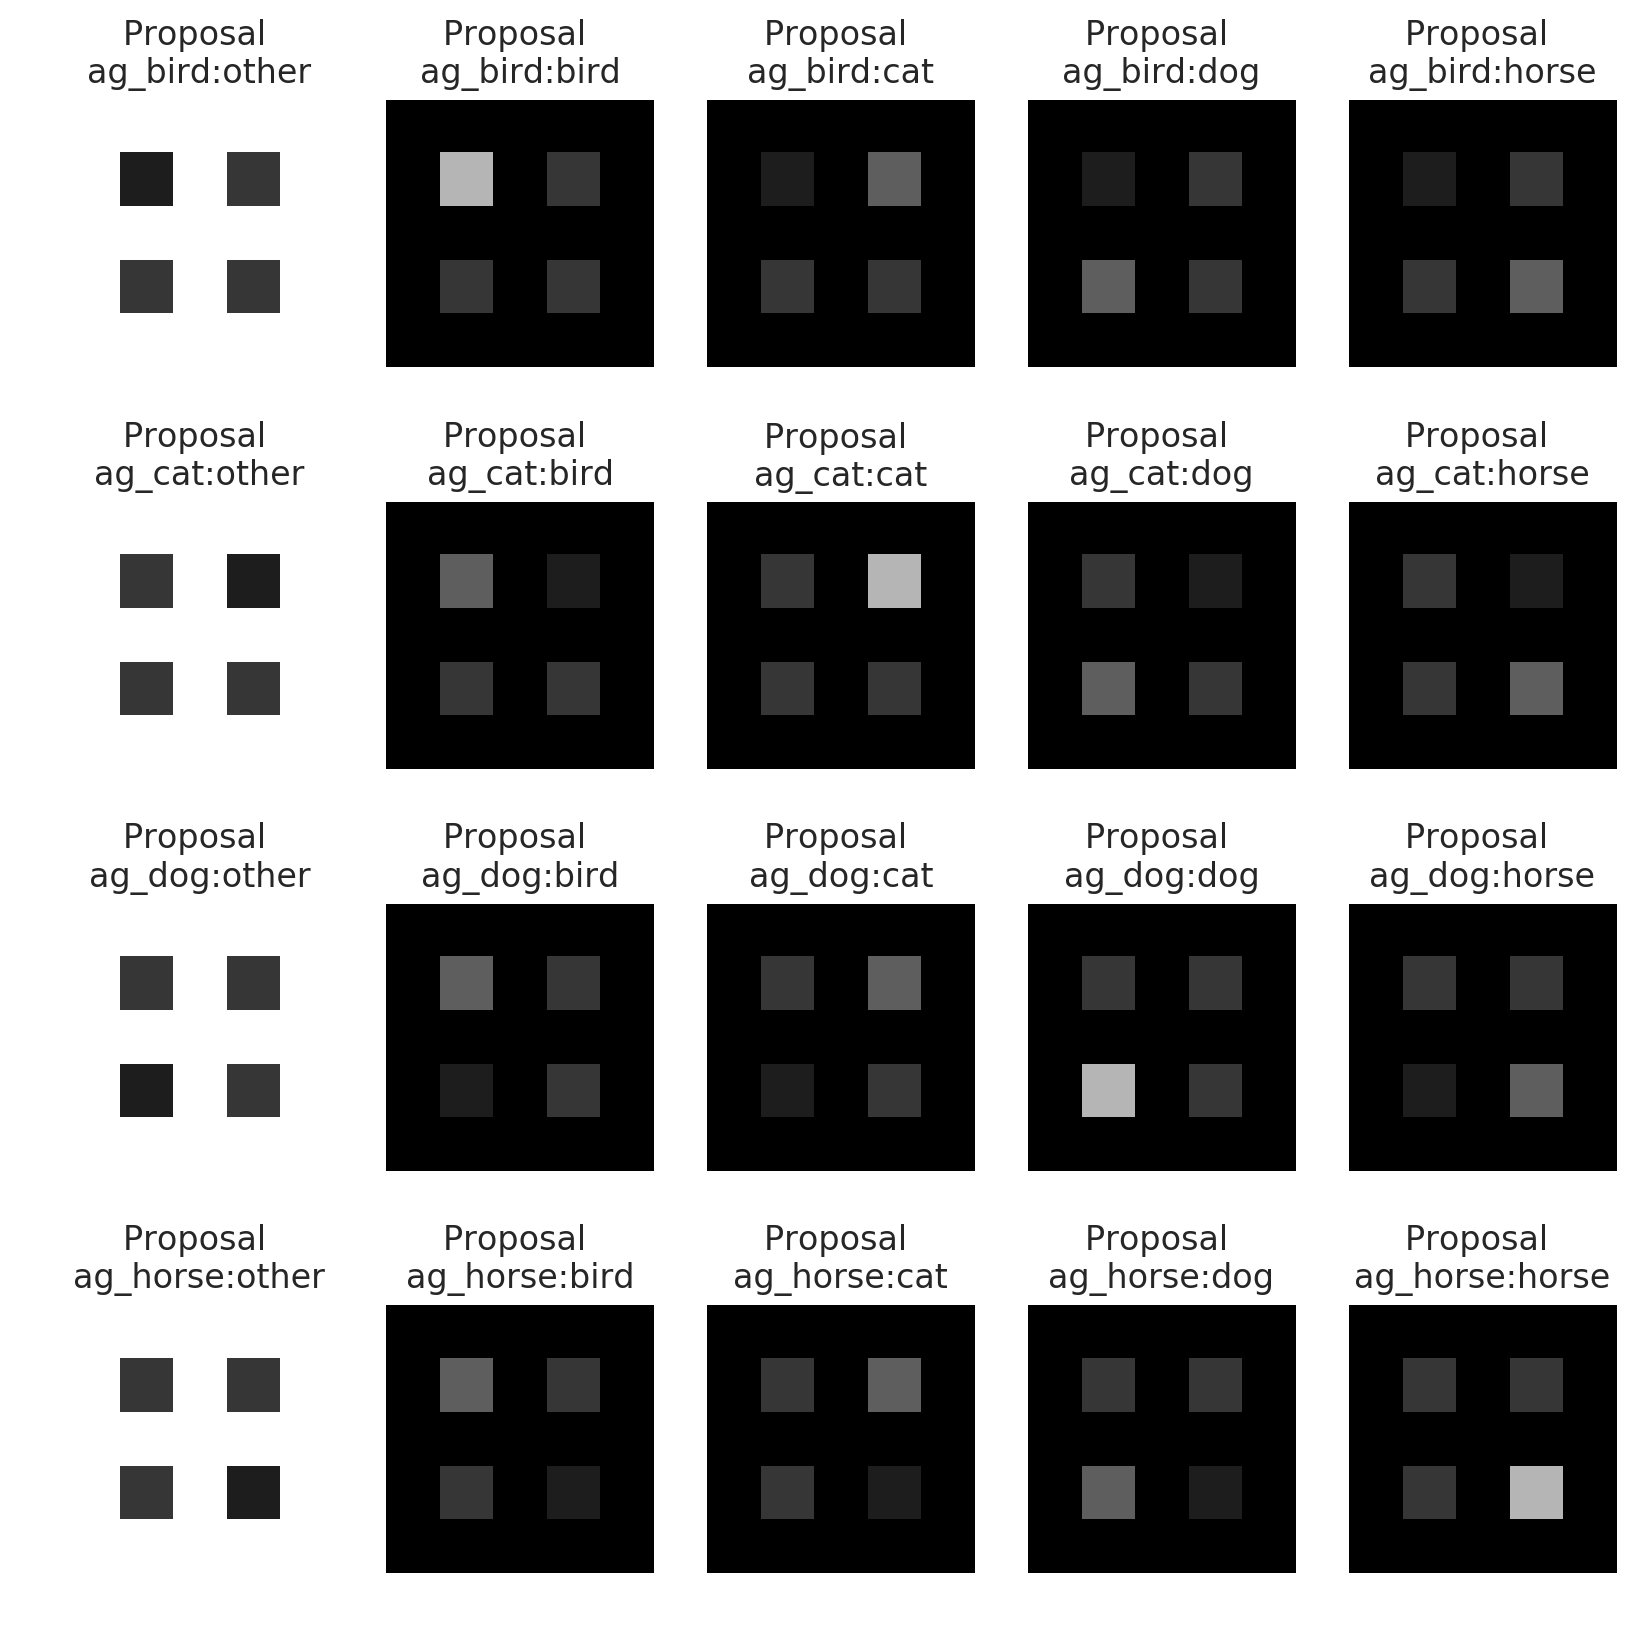

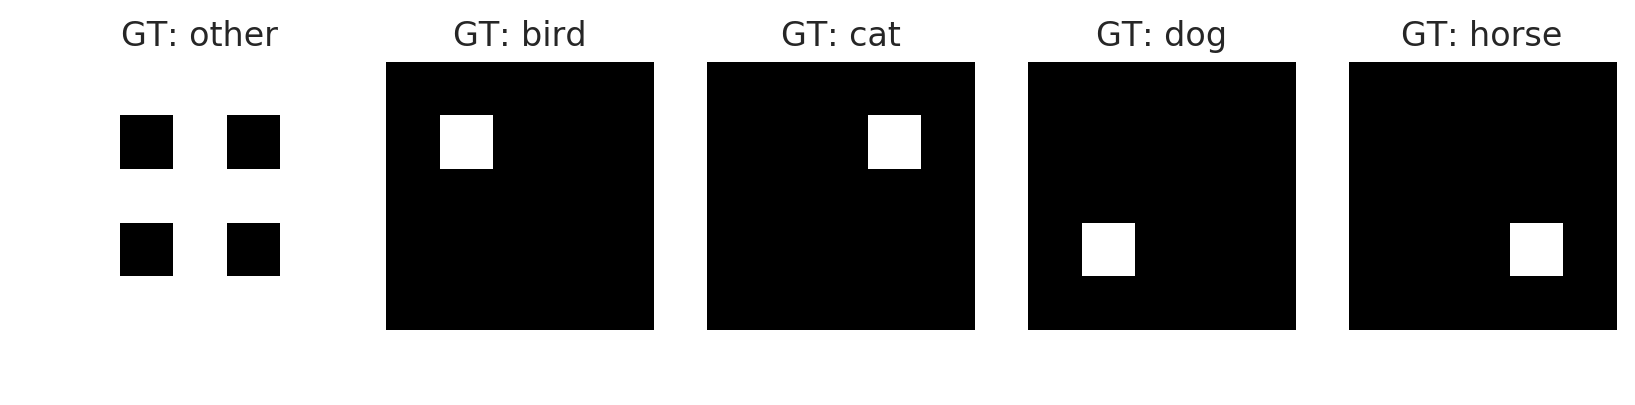

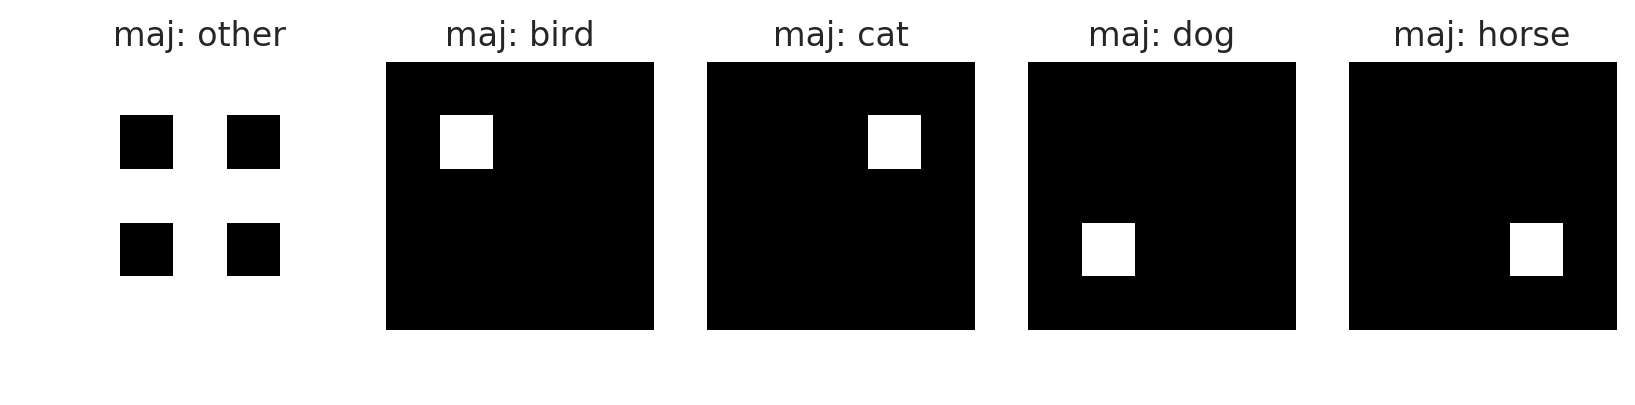

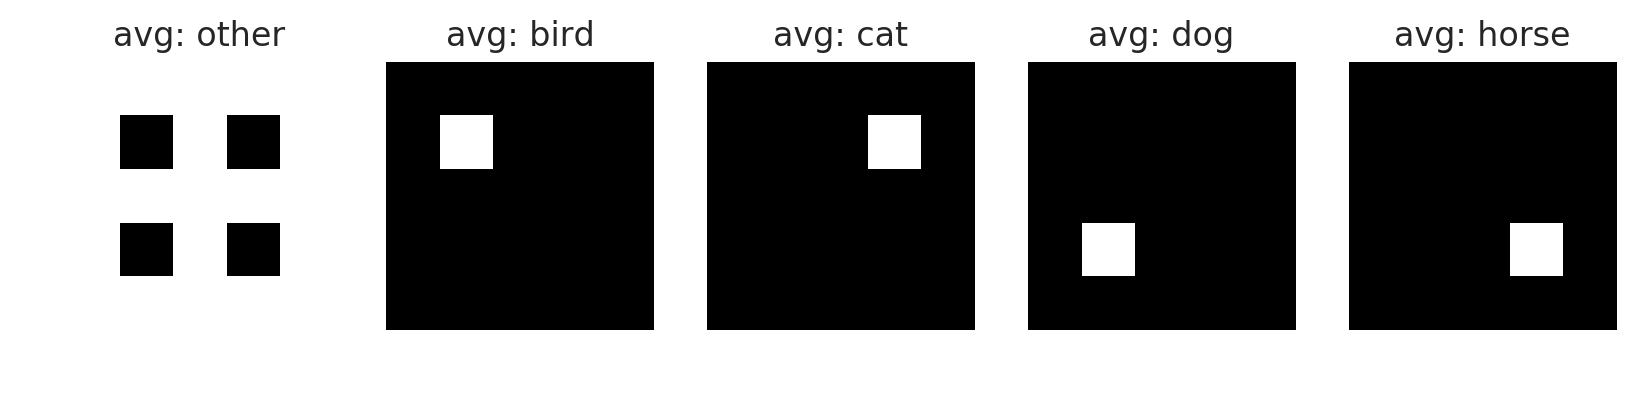

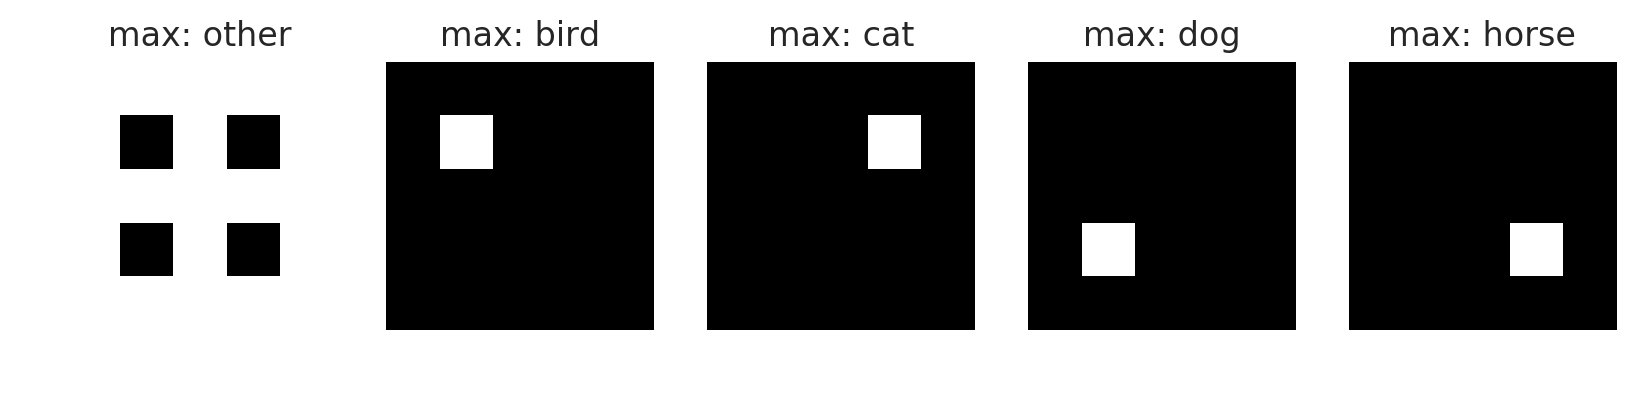

In [11]:
template = templates['multi_sq']
exp_2 = lambda a, b: generate_samples(template, objects_gt=[0, 1, 2, 3, 4], confidences=exp_2_confidences(a, b, template))
#data = robustness(exp_1, amin=1/5, bmin=1/5)
gt, prop = exp_2(0.6, 0.3)
agr_majority = neg.compute_majority_voting(prop, binary_strategy='maximum')
agr_mean = neg.mean_proposal(prop,  binary_strategy='maximum')
agr_max = neg.max_proposal(prop)

nt.plot(proposals=prop, ground_truth=gt)
nt.plot(agreement=agr_majority, agreement_title='maj')
nt.plot(agreement=agr_mean, agreement_title='avg')
nt.plot(agreement=agr_max, agreement_title='max')
plt.show()

## 2
Template: Multiple boxes

In [223]:
def exp_3_confidences(a, b):
    '''
    Generate a confidence matrix for the experiment 1
    a: Confidence of agent 1 in label 1
    b: Confidence of agents 2, 3, 4 in label 2
    '''
    nota = (1-a)/(len(CHANNEL_NAMES)-1)
    notb = (1-b)/(len(CHANNEL_NAMES)-1)
    confidences = list()
    for ag in range(len(AGENT_NAMES)):
        if ag == 0:
            labs = list()
            for lab in range(len(CHANNEL_NAMES)):
                labs.append(a if lab==1 else nota)
            confidences.append([labs])
        else:
            labs = list()
            for lab in range(len(CHANNEL_NAMES)):
                labs.append(b if lab==2 else notb)
            confidences.append([labs])        
    return confidences

exp_1 = lambda a, b: generate_samples(templates['single_sq'], objects_gt=[0, 1], confidences=exp_1_confidences(a, b))
#data = robustness(exp_1, amin=1/5, bmin=1/5)
gt, prop = exp_1(0.5, 0.6)
agr_majority = neg.compute_majority_voting(prop, binary_strategy='maximum')
agr_mean = neg.mean_proposal(prop,  binary_strategy='maximum')
agr_max = neg.max_proposal(prop)


# nt.plot(proposals=prop, ground_truth=gt)
# nt.plot(agreement=agr_majority, agreement_title='maj')
# nt.plot(agreement=agr_mean, agreement_title='avg')
# nt.plot(agreement=agr_max, agreement_title='max')


{'exp_1_bird_f1-score': 0.0,
 'exp_1_bird_precision': 0.0,
 'exp_1_bird_recall': 0.0,
 'exp_1_bird_support': 9.0,
 'exp_1_cat_f1-score': 0.0,
 'exp_1_cat_precision': 0.0,
 'exp_1_cat_recall': 0.0,
 'exp_1_cat_support': 0.0,
 'exp_1_dog_f1-score': 0.0,
 'exp_1_dog_precision': 0.0,
 'exp_1_dog_recall': 0.0,
 'exp_1_dog_support': 0.0,
 'exp_1_horse_f1-score': 0.0,
 'exp_1_horse_precision': 0.0,
 'exp_1_horse_recall': 0.0,
 'exp_1_horse_support': 0.0,
 'exp_1_macro avg_f1-score': 0.0,
 'exp_1_macro avg_precision': 0.0,
 'exp_1_macro avg_recall': 0.0,
 'exp_1_macro avg_support': 9.0,
 'exp_1_micro avg_f1-score': 0.0,
 'exp_1_micro avg_precision': 0.0,
 'exp_1_micro avg_recall': 0.0,
 'exp_1_micro avg_support': 9.0,
 'exp_1_other_f1-score': 0.0,
 'exp_1_other_precision': 0.0,
 'exp_1_other_recall': 0.0,
 'exp_1_other_support': 0.0,
 'exp_1_weighted avg_f1-score': 0.0,
 'exp_1_weighted avg_precision': 0.0,
 'exp_1_weighted avg_recall': 0.0,
 'exp_1_weighted avg_support': 9.0}

In [221]:
np.logical_not(consensus)

array([[False, False, False, False, False],
       [False, False, False, False, False],
       [False, False, False, False, False],
       [False, False, False, False, False],
       [False, False, False, False, False]])

In [216]:
gt.argmax(axis=-1)

array([[0, 0, 0, 0, 0],
       [0, 1, 1, 1, 0],
       [0, 1, 1, 1, 0],
       [0, 1, 1, 1, 0],
       [0, 0, 0, 0, 0]])